##Libs

In [ ]:
!pip install geopandas

In [ ]:
!pip install https://github.com/python-visualization/folium/archive/master.zip

In [ ]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import json
from shapely.geometry import Point, Polygon, LineString, MultiLineString, MultiPolygon, shape, MultiPoint
import shapely.wkt
from shapely.ops import unary_union
import folium
import folium.plugins
import branca.colormap as cm
import base64
import requests

##Files

In [ ]:
data_kr = pd.read_excel('/arch-data.xlsx', header=0)

In [ ]:
data_kr['color'] = 0

##Preproc

In [ ]:
#получить слои по названию из json
def get_layers(j, layer):
  l = []
  for feature in j['features']:
     if feature['properties']['layer'] == layer:
       l.append(feature)
  return(l)

#получить объект Геометрия
def geom(j):
  return shape(j)

#переделать в geodataframe
def to_gdf(lst):
  gdf = geopandas.GeoDataFrame(lst)
  gdf.crs = 'EPSG:4326'
  gdf['geometry'] = gdf['geometry'].apply(geom)
  return gdf


#получить gdf по названию слоя
def get_gdf(name):
  return to_gdf(get_layers(k, name))['geometry']

#соединить полигоны в мульти
def get_multipoly(name):
  return MultiPolygon(to_gdf(get_layers(k, name))['geometry'].values)

In [ ]:
krom = to_gdf(get_layers(k, 'ARCHITECTURE'))

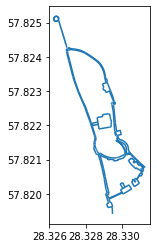

In [ ]:
krom.plot()

На некоторых слоях в AutoCAD несколько раскопов, поэтому я разъединяю их вручную:



In [ ]:
print(get_multipoly('1991-1'))

MULTIPOLYGON (((28.33591250168689 57.81891985703351, 28.33602727286927 57.81900558046917, 28.33575601172279 57.81911105963539, 28.33565340831302 57.81910291593138, 28.33561239489313 57.81884990354834, 28.33577657974047 57.81897082473324, 28.33591250168689 57.81891985703351)), ((28.33630121904213 57.81839034871803, 28.33604201808356 57.81840188044967, 28.33603980964628 57.81838421758388, 28.33629828955256 57.81837264642223, 28.33630121904213 57.81839034871803)), ((28.3359607546673 57.81825170764355, 28.33597739705309 57.81825087670572, 28.33598052031107 57.81826858742178, 28.33594723555299 57.81827024930021, 28.33594723555299 57.81828049503744, 28.3358822276457 57.81828242840677, 28.33587910437419 57.81826471769389, 28.33596231630304 57.8182605630025, 28.3359607546673 57.81825170764355)))


##Map

In [ ]:
min_lat = 57.5
min_lon = 28
max_lat = 58
max_lon = 29


m = folium.Map(location=[57.821000, 28.331000],
               position = 'absolute',
               zoom_start = 16, max_zoom = 19, min_zoom = 12, 
               tiles= None, 
               control_scale=True,
               min_lat=min_lat,
               max_lat=max_lat,
               min_lon=min_lon,
               max_lon=max_lon,
               prefer_canvas=True,
               max_bounds=True)
folium.TileLayer('https://api.mapbox.com/styles/v1/c0chonnet/ckbz7ey6x3okt1io3g400sx6a/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiYzBjaG9ubmV0IiwiYSI6ImNrYno3NGtlbTA1ZDgzM3BtbDhzNGNnbGoifQ.eRl5T1mXLzwFZsxx0K942A', 
                 name='Карта', attr = '© Mapbox © OpenStreetMap').add_to(m)

folium.GeoJson(krom,name = 'Кремль',  style_function = lambda x: {'color': '#724F0C', 'opacity': 1, 'weight': 2, 'fillOpacity':0},tooltip='Кремль').add_to(m)

Здесь цветовая схема для раскопов

In [ ]:
clrs = [(244,236,161),(209,34,2)]
cmap = cm.LinearColormap(colors=clrs, vmin= min(data_kr.date_max), vmax=max(data_kr.date_max))
cmap = cmap.to_step(index=range(10,21))
cmap

In [ ]:
data_kr['color'] = data_kr['date_min'].map(cmap)

Здесь остаются только строки с заполненной геометрией

In [ ]:
data_kr['geometry'] = data_kr['geometry'].fillna(0)
test = data_kr[data_kr['geometry'] != 0]

for i in test.index:
  try:
    test['geometry'][i] = shapely.wkt.loads(test['geometry'][i])
  except TypeError:
    test['geometry'][i]=test['geometry'][i]
test = geopandas.GeoDataFrame(test)
test.crs = 'EPSG:4326'

##Popup

Фотография

In [ ]:
test['photo'].fillna(0, inplace=True)
test['ph_caption'].fillna(0, inplace=True)
test['hdr'] = 0

for i in test.index:
  if test['photo'][i] != 0 and test['ph_caption'][i] != 0:
      img = base64.b64encode(requests.get(test['photo'][i]).content).decode()
      hdr = '<img src="data:image/JPG;base64,{}", width="100%", height = "40%", style="object-fit: cover;"><br><i>{}</i><br><br>'.format(img, test['ph_caption'][i])
      test['hdr'][i] = hdr
  elif test['photo'][i] != 0 and test['ph_caption'][i] == 0:
      img = base64.b64encode(requests.get(test['photo'][i]).content).decode()
      hdr = '<img src="data:image/JPG;base64,{}", width="100%", height = "40%", style="object-fit: cover;">'.format(img)
      test['hdr'][i] = hdr
  else:
       test['hdr'][i] = ''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/

Датировка

In [ ]:
for i in test.index:
  test['date_min'][i] = '<b>Датировка раскопа: </b><span style="background-color:{}; color: black; padding: 5px">{}-{} вв</span><br>'.format(test['color'][i],
                                                                                                              test['date_min'][i],
                                                                                                              test['date_max'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Автор

In [ ]:
test['link_author'] = test['link_author'].fillna(0)
for i in test.index:
  if test['link_author'][i] != 0:
    test['author'][i] = '<b><a href ="{}" target = "_blank" >{}</a></b><br><br> '.format(test['link_author'][i], test['author'][i])
  else: test['author'][i] = '<b>{}</b><br><br>'.format(test['author'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Результат

In [ ]:
test['result'] = test['result'].fillna(0)
for i in test.index:
  if test['result'][i] == 0:
    test['result'][i] = ''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


##GeoJson

In [ ]:
g1959 = folium.GeoJson(test[(test['year'] >= 1930) & (test['year'] <= 1959)],
                        name="1930-1959",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1960 = folium.GeoJson(test[(test['year'] == 1960)],
                        name="1960",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1961 = folium.GeoJson(test[(test['year'] == 1961)],
                        name="1961",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1962 = folium.GeoJson(test[(test['year'] == 1962)],
                        name="1962",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1966 = folium.GeoJson(test[(test['year'] == 1966)],
                        name="1966",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1967 = folium.GeoJson(test[(test['year'] == 1967)],
                        name="1967",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1968 = folium.GeoJson(test[(test['year'] == 1968)],
                        name="1968",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1969 = folium.GeoJson(test[(test['year'] == 1969)],
                        name="1969",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1970 = folium.GeoJson(test[(test['year'] == 1970)],
                        name="1970",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1971 = folium.GeoJson(test[(test['year'] == 1971)],
                        name="1971",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1972 = folium.GeoJson(test[(test['year'] == 1972)],
                        name="1972",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1973 = folium.GeoJson(test[(test['year'] == 1973)],
                        name="1973",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1974 = folium.GeoJson(test[(test['year'] == 1974)],
                        name="1974",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1976 = folium.GeoJson(test[(test['year'] == 1976)],
                        name="1976",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1978 = folium.GeoJson(test[(test['year'] == 1978)],
                        name="1978",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1979 = folium.GeoJson(test[(test['year'] == 1979)],
                        name="1979",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1980 = folium.GeoJson(test[(test['year'] == 1980)],
                        name="1980",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1981 = folium.GeoJson(test[(test['year'] == 1981)],
                        name="1981",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1982 = folium.GeoJson(test[(test['year'] == 1982)],
                        name="1982",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1983 = folium.GeoJson(test[(test['year'] == 1983)],
                        name="1983",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1984 = folium.GeoJson(test[(test['year'] == 1984)],
                        name="1984",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1985 = folium.GeoJson(test[(test['year'] == 1985)],
                        name="1985",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1986 = folium.GeoJson(test[(test['year'] == 1986)],
                        name="1986",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1987 = folium.GeoJson(test[(test['year'] == 1987)],
                        name="1987",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1988 = folium.GeoJson(test[(test['year'] == 1988)],
                        name="1988",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1989 = folium.GeoJson(test[(test['year'] == 1989)],
                        name="1989",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1990 = folium.GeoJson(test[(test['year'] == 1990)],
                        name="1990",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1991 = folium.GeoJson(test[(test['year'] == 1991)],
                        name="1991",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

In [ ]:
g1992 = folium.GeoJson(test[(test['year'] == 1992)],
                        name="1992",
                   style_function = lambda x: {'color': 'black', 'opacity': 0,
                                           'fillColor': x['properties']['color'], 'fillOpacity': 0.8},
                   highlight_function=lambda x: {'weight':3, 'color':'white', 'opacity': 1,
                                                 'fillColor': x['properties']['color'], 'fillOpacity': 1},
                        popup=folium.features.GeoJsonPopup(fields=['hdr','date_min','author','result'], labels=False,
                                                       style='padding:0, font-family: Verdana, sans-serif; opacity: 0.9;max-height: 500px')).add_to(m)

##LayerControl

In [ ]:
folium.LayerControl(position='bottomright', collapsed=False).add_to(m)

In [ ]:
m

In [ ]:
#m.save('/content/drive/MyDrive/Псков GIS/arch.html')